In [1]:
# configuration
config = {
    'FILE_PATH': '/Users/pradeep/Desktop/ProjectANotebooks/notebooks/cleaned_incidents1.csv'
    }
config

{'FILE_PATH': '/Users/pradeep/Desktop/ProjectANotebooks/notebooks/cleaned_incidents1.csv'}

In [2]:
# import libraries
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import string
    import re
    from time import time
    from imblearn.over_sampling import SMOTE
    import texthero as hero
    from texthero import preprocessing
    from gensim.models import Word2Vec
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    from sklearn.preprocessing import LabelEncoder
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report, ConfusionMatrixDisplay
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import StackingClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.svm import SVC
    import pickle
    import warnings
except(ImportError):
    print(f'Import Error: {ImportError}')

# ignore warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# set seeds for reproducability
from numpy.random import seed
seed(500)

# global configurations
pd.set_option("display.max_colwidth", -1) # show larger text in pandas dataframe

In [3]:
'''
- select features
- drop missing values
- combine selected features into one
'''
def data(df):
    new_df = df[['EventDescription', 'FailedAssets', 'IncidentCause', 'IncidentConsequence', 'IncidentType', 'Status', 'WeatherStation', 'Category']]
    new_df.dropna(axis=0, inplace=True)
    features = new_df['EventDescription'] +' ' + new_df['IncidentCause'] + ' '+ new_df['IncidentConsequence']
    target = new_df['Category']
    return features, target

In [4]:
# read csv
dataset = pd.read_csv(config['FILE_PATH'])

# get features and target
features, target = data(dataset)

# Text Cleaning and Pre-processing
def preprocess_text():
    # cleaning steps
    cleaning_pipeline = [
        preprocessing.fillna,
        preprocessing.lowercase,
        preprocessing.remove_whitespace,
        preprocessing.remove_punctuation,
        preprocessing.remove_urls,
        preprocessing.remove_brackets,
        preprocessing.remove_stopwords,
        preprocessing.remove_digits,
        preprocessing.remove_angle_brackets,
        preprocessing.remove_curly_brackets,
        preprocessing.stem
        #preprocessing.tokenize
    ]

    # apply pipeline to text
    clean_text = features.pipe(hero.clean, cleaning_pipeline)

    return clean_text

In [5]:
# check processed text
clean_text = preprocess_text()
clean_text

0       nearbi custom report spark electr line locat attend crew found high voltag abc conductor fault midspan result ground fire approx sqm report injuri hvabc cabl fault midspan grassfir                                                                                                                                                                                                               
1       contractor report contact earth cabl excav trench locat arriv crew found contractor denni jame ph dig trench contact earth cabl caus damag cabl report injuri third parti properti damag contractor contact earth conductor go zone contact                                                                                                                                                        
2       field crew attend outag found 22kv conductor broken due rust connect sleev fallen ground one end remain aliv due high imped backfe downlin transform wind protect oper report injuri third parti propert

In [6]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(clean_text, target, random_state=0, test_size=0.25, shuffle=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4866,), (1622,), (4866,), (1622,))

In [7]:
# feature extraction methods
# tfidf
def tfidf():
    vectorizer = TfidfVectorizer(analyzer='word', max_features=1000)
    vectorizer.fit(clean_text)
    # dump tfidf
    pickle.dump(vectorizer, open('TFIDF_1000.pickle', 'wb'))
    train_tfidf = vectorizer.transform(x_train)
    test_tfidf = vectorizer.transform(x_test)
    return train_tfidf, test_tfidf

# bow
def bow():
    count_vectorizer = CountVectorizer(analyzer='word', max_features=1000)
    count_vectorizer.fit(clean_text)
    train_bow = count_vectorizer.transform(x_train)
    test_bow = count_vectorizer.transform(x_test)
    return train_bow, test_bow

# bigrams
def bigrams():
    bigram_vectorizer = CountVectorizer(analyzer='word', ngram_range=(2,2), max_features=1000)
    bigram_vectorizer.fit(clean_text)
    train_bigram = bigram_vectorizer.transform(x_train)
    test_bigram = bigram_vectorizer.transform(x_test)
    return train_bigram, test_bigram

In [8]:
# get features
train_tfidf, test_tfidf = tfidf()
train_tfidf.shape, test_tfidf.shape

train_bigram, test_bigram = bigrams()

train_bow, test_bow = bow()

In [9]:
oversample = SMOTE(random_state=0,n_jobs=-1,k_neighbors=5)
train_tfidf, y_train = oversample.fit_resample(train_tfidf, y_train)
print(f'Shape: {train_tfidf.shape}')
print(y_train.value_counts())

Shape: (15090, 1000)
Dug up          1006
AF Other        1006
OH Cable        1006
UG Cable        1006
Fuse            1006
Other           1006
Connection      1006
Crossarm        1006
Conductor       1006
Vehicle         1006
Trees           1006
Animal          1006
Pole            1006
Lightning       1006
Installation    1006
Name: Category, dtype: int64


In [10]:
'''# grid search
param_grid = {
    'n_estimators': [1000, 1500, 2000],
    'max_depth' : [10, 15, 20],
    #'min_samples_leaf' :[2]
}
CV_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=0),
                      param_grid=param_grid, cv= 5, n_jobs=-1, scoring='f1_micro')
CV_rfc.fit(train_tfidf, y_train)
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)'''

"# grid search\nparam_grid = {\n    'n_estimators': [1000, 1500, 2000],\n    'max_depth' : [10, 15, 20],\n    #'min_samples_leaf' :[2]\n}\nCV_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=0),\n                      param_grid=param_grid, cv= 5, n_jobs=-1, scoring='f1_micro')\nCV_rfc.fit(train_tfidf, y_train)\nprint(CV_rfc.best_params_)\nprint(CV_rfc.best_score_)"

In [11]:
# random forest classifier
rf = RandomForestClassifier(random_state=0, n_estimators=800, max_depth=20, min_samples_leaf=50, max_features='sqrt', criterion='gini', n_jobs=-1)

# fit
rf.fit(train_tfidf, y_train)

# dump model
pickle.dump(rf, open('random_forest.pickle', 'wb'))

# predict
y_pred = rf.predict(test_tfidf)

# accuracy
print(accuracy_score(y_test, y_pred))

# classification report
print(classification_report(y_test, y_pred))

# F-measure
from sklearn.metrics import f1_score
f1score = f1_score(y_test, y_pred, average='micro')
print(f'F-Measure: {f1score}')


0.7540073982737361
              precision    recall  f1-score   support

    AF Other       0.53      0.46      0.49        91
      Animal       0.88      0.80      0.84        75
   Conductor       0.36      0.54      0.43        39
  Connection       0.83      0.61      0.70       227
    Crossarm       0.80      0.92      0.86       116
      Dug up       0.72      0.95      0.82        99
        Fuse       0.81      0.86      0.83       105
Installation       0.06      0.29      0.10         7
   Lightning       0.79      0.91      0.85        33
    OH Cable       0.47      0.73      0.57        59
       Other       0.91      0.74      0.81       315
        Pole       0.63      0.55      0.59        84
       Trees       0.89      0.91      0.90       138
    UG Cable       0.24      0.67      0.35         6
     Vehicle       0.84      0.82      0.83       228

    accuracy                           0.75      1622
   macro avg       0.65      0.72      0.66      1622
weighte

In [12]:
# imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ClassPredictionError
from mlxtend.plotting import plot_learning_curves
from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report

# global settings
plt.style.use('classic')
matplotlib.rcParams['figure.figsize'] = (20, 10)

In [13]:
# evaluation metrics for imbalanced data
def model_evaluation(model, x_train, y_train, x_test, y_test, model_name, y_pred):
    """:arg
    :model, classifier, must have .fit() and .predict()
    :x_train, X, features
    :y_train, y, target
    :x_test, test features
    :y_test, test target
    :model_name, name of the classifier, string
    :y_pred, prediction made by classifier
    """
    # accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f'The accuracy for {model_name}: {acc}')

    # F-measure
    f1score = f1_score(y_test, y_pred, average='micro')
    print(f'F-Measure for {model_name}: {f1score}')

    # Recall
    recallscore = f1_score(y_test, y_pred, average='micro')
    print(f'Recall for {model_name}: {recallscore}')

    # classification report
    visualizer = ClassificationReport(model, support=True, cmap='spectral')

    visualizer.fit(x_train, y_train)        # Fit the visualizer and the model
    visualizer.score(x_test, y_test)        # Evaluate the model on the test data
    visualizer.show()

    # Generate confusion matrix
    matrix = plot_confusion_matrix(model, x_test, y_test, cmap=plt.cm.Blues)
    plt.title(f'Confusion matrix for {model_name} classifier')
    plt.xticks(rotation=65)
    plt.show(matrix)
    plt.show()

    # precision recall curve
    # Create the visualizer, fit, score, and show it
    viz = PrecisionRecallCurve(
        model,
        per_class=True,
        cmap="Set1", classes=np.unique(y_train),
        colors=["purple", "cyan", "slategray", "red", "grey", "yellow", "maroon", "gold", "orange", "olive", "brown", "deeppink", 'darkkhaki', "black", "navy"]
    )
    viz.fit(x_train, y_train)
    viz.score(x_test, y_test)
    viz.show()

    # class prediction error
    # Instantiate the classification model and visualizer
    visualizer = ClassPredictionError(
        model,
        colors=["purple", "cyan", "slategray", "red", "grey", "yellow", "maroon", "gold", "orange", "olive", "brown", "deeppink", 'darkkhaki', "black", "navy"]
    )

    # Fit the training data to the visualizer
    visualizer.fit(x_train, y_train)

    # Evaluate the model on the test data
    visualizer.score(x_test, y_test)

    # Draw visualization
    visualizer.show()

    # Create the learning curve visualizer
    cv = StratifiedKFold(n_splits=10)
    sizes = np.linspace(0.3, 1.0, 10)

    # Instantiate the classification model and visualizer
    visualizer = LearningCurve(
        model, cv=cv, scoring='f1_micro', train_sizes=sizes, n_jobs=4
    )

    visualizer.fit(x_train, y_train)        # Fit the data to the visualizer
    visualizer.show()

    # learning curve with train and test data
    plot_learning_curves(x_train, y_train, x_test, y_test, model, train_marker='o', test_marker='^',
                     scoring='misclassification error', suppress_plot=False, print_model=True, legend_loc='best')


The accuracy for Random Forest: 0.7540073982737361
F-Measure for Random Forest: 0.754007398273736
Recall for Random Forest: 0.754007398273736


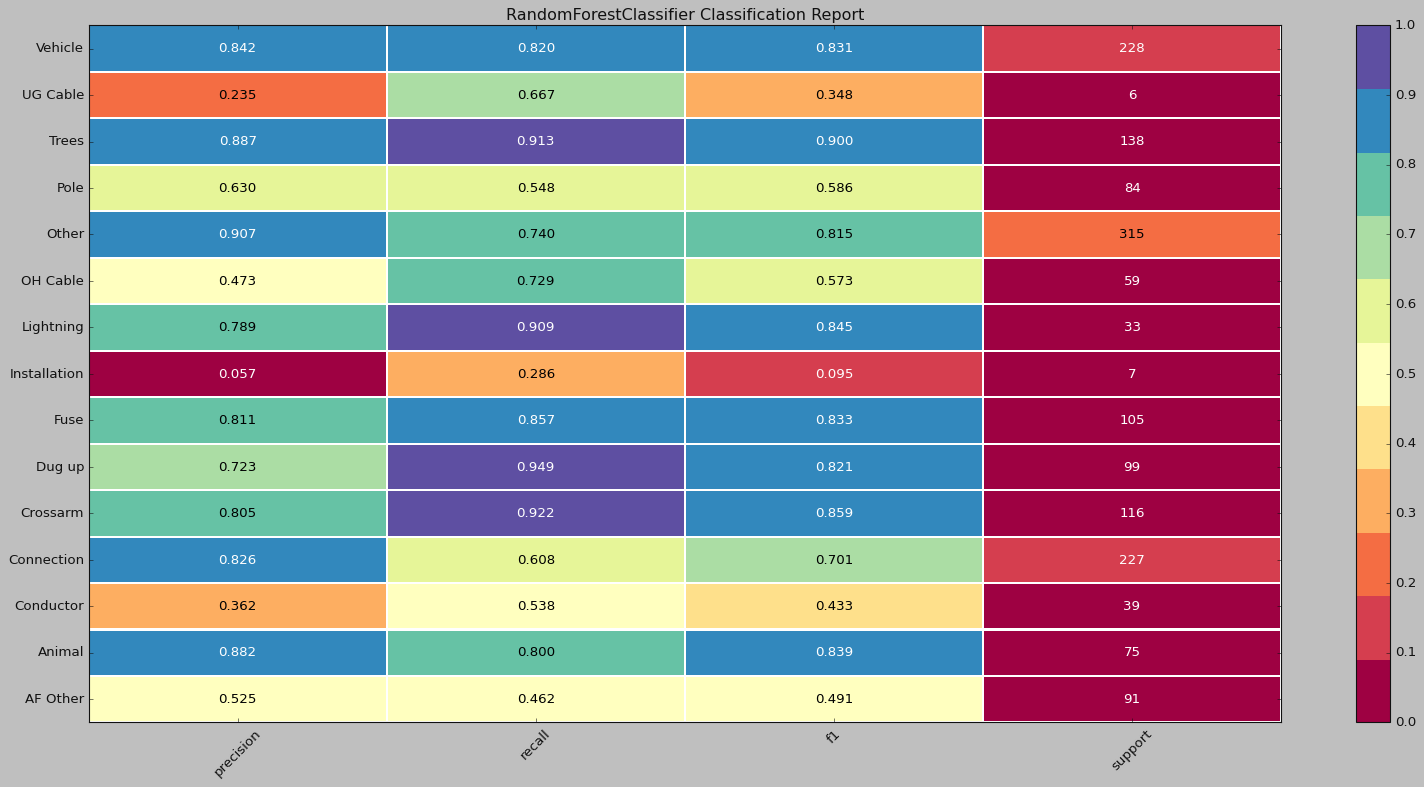

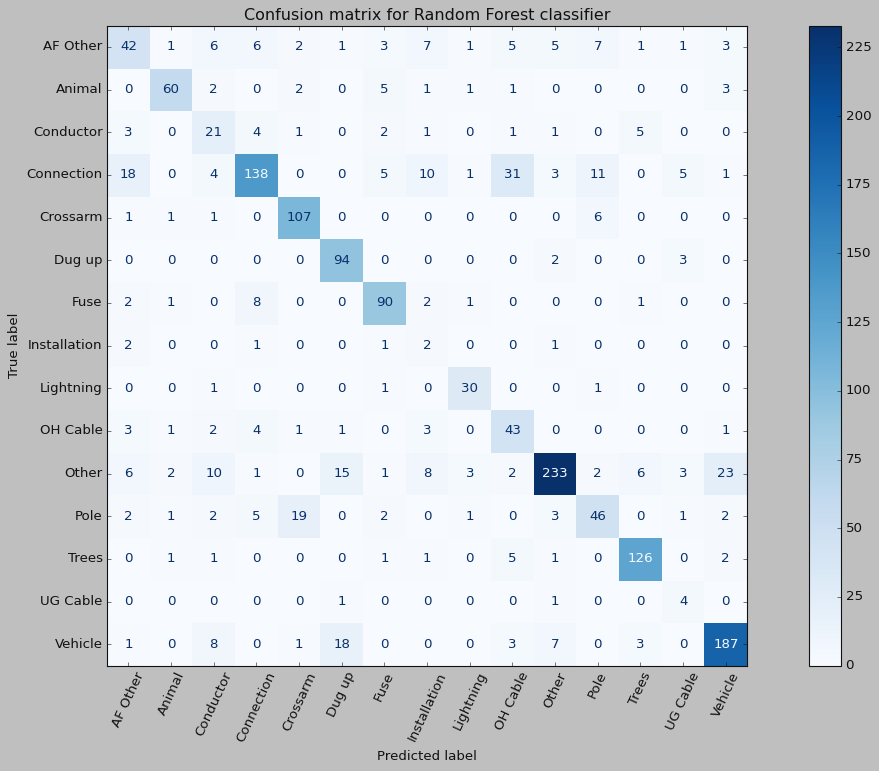

In [ ]:
model_evaluation(rf, train_tfidf, y_train, test_tfidf, y_test, 'Random Forest', y_pred)
